## Regional Ocean: Basic Region and Surface Field Visualization

Note: This notebook is meant to be run with the cupid-analysis kernel (see [CUPiD Installation](https://ncar.github.io/CUPiD/index.html#installing)). This notebook is often run by default as part of [CESM post-processing steps](https://ncar.github.io/CUPiD/run_cesm.html), but you can also run it manually.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
from glob import glob

import cartopy
import matplotlib.pyplot as plt
import numpy as np
import regional_utils as utils
import xarray as xr
from cartopy import crs as ccrs
from cartopy import feature as cfeature

In [2]:
CESM_output_dir = ""  # "CROCODILE_tutorial_nwa12_MARBL"
case_name = ""  # "/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/Diagnostics/CESM_Output/"

## No timeseries or base case used in this notebook
ts_dir = None
base_case_output_dir = None
base_case_name = None

## As regional domains vary so much in purpose, simulation length, and extent, we don't want to assume a minimum duration
## Thus, we ignore start and end dates and simply reduce/output over the whole time frame for all of the examples given.
start_date = None  # "0001-01-01"
end_date = None  # "0101-01-01"
base_start_date = None  # "0001-01-01"
base_end_date = None  # "0101-01-01"

obs_data_dir = None

savefigs = False
fig_output_dir = None

serial = False  # use dask LocalCluster

lc_kwargs = {}

In [3]:
# Parameters
case_name = "CROCODILE_tutorial_nwa12_MARBL"
base_case_name = None
CESM_output_dir = (
    "/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/Diagnostics/CESM_Output/"
)
start_date = "2000-01-01"
end_date = "2000-11-01"
base_start_date = ""
base_end_date = ""
lc_kwargs = {"threads_per_worker": 1}
savefigs = True
fig_output_dir = None
serial = True
subset_kwargs = {}
product = "/glade/work/ajanney/CUPiD/examples/regional_ocean/computed_notebooks//ocn/Regional_Ocean_Report_Card.ipynb"


In [4]:
# Parameters for testing (from default examples/regional_ocean/config.yml)
# case_name = "CROCODILE_tutorial_nwa12_MARBL"
# base_case_name = None
# CESM_output_dir = (
#     "/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/Diagnostics/CESM_Output/"
# )
# start_date = "2000-01-01"
# end_date = "2000-11-01"
# base_start_date = ""
# base_end_date = ""
# lc_kwargs = {"threads_per_worker": 1}
# savefigs = True
# fig_output_dir = None
# serial = True

# subset_kwargs = {}

In [5]:
OUTDIR = os.path.join(CESM_output_dir, case_name, "ocn", "hist")
print("Output directory is:", OUTDIR)

Output directory is: /glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/Diagnostics/CESM_Output/CROCODILE_tutorial_nwa12_MARBL/ocn/hist


## Load in Model Output and Look at Variables/Meta Data

#### Default File Structure in MOM6
This file structure will be different if you modify the diag_table.

- **static data**: contains horizontal grid, vertical grid, land/sea mask, bathymetry, lat/lon information
- **sfc data**: daily output of 2D surface fields (salinity, temp, SSH, velocities)
- **monthly data**: averaged monthly output of the full 3D domain, regridded to a predefined grid (MOM6 default is WOA, see more below)
- **native data**: averaged monthly output of ocean state and atmospheric fluxes on the native MOM6 grid

In [6]:
# Xarray time decoding things
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

## Static data includes hgrid, vgrid, bathymetry, land/sea mask
static_data = xr.open_mfdataset(
    os.path.join(OUTDIR, f"*h.static.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Surface Data
sfc_data = xr.open_mfdataset(
    os.path.join(OUTDIR, f"*h.sfc*.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Monthly Full Domain Data
## Not used in this notebook by default
monthly_data = xr.open_mfdataset(
    os.path.join(OUTDIR, f"*h.z*.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Monthly Full Domain Data, on native MOM6 grid
## Not used in this notebook by default
native_data = xr.open_mfdataset(
    os.path.join(OUTDIR, f"*h.native*.nc"),
    decode_timedelta=True,
    decode_times=time_coder,
    engine="netcdf4",
)

## Image/Gif Output Directory
if fig_output_dir is None:
    image_output_dir = os.path.join(
        "/glade/derecho/scratch/",
        os.environ["USER"],
        "archive",
        case_name,
        "ocn",
        "cupid_images",
    )
else:
    image_output_dir = os.path.join(fig_output_dir, case_name, "ocn", "cupid_images")
if not os.path.exists(image_output_dir):
    os.makedirs(image_output_dir)
print("Image output directory is:", image_output_dir)

Image output directory is: /glade/derecho/scratch/ajanney/archive/CROCODILE_tutorial_nwa12_MARBL/ocn/cupid_images


In [7]:
## Apply time boundaries
if start_date is not None and end_date is not None:
    import cftime

    calendar = sfc_data.time.encoding.get("calendar", "standard")

    calendar_map = {
        "gregorian": cftime.DatetimeProlepticGregorian,
        "noleap": cftime.DatetimeNoLeap,
    }

    CFTime = calendar_map.get(calendar, cftime.DatetimeGregorian)
    y, m, d = [int(i) for i in start_date.split("-")]
    start_date_time = CFTime(y, m, d)
    y, m, d = [int(i) for i in end_date.split("-")]
    end_date_time = CFTime(y, m, d)

    print(
        f"Applying time range from start_date: {start_date_time} and end_date: {end_date_time}."
    )

    sfc_data = sfc_data.sel(time=slice(start_date_time, end_date_time))
    monthly_data = monthly_data.sel(time=slice(start_date_time, end_date_time))
    native_data = native_data.sel(time=slice(start_date_time, end_date_time))

sfc_time_bounds = [
    sfc_data["time"].isel(time=0).compute().item(),
    sfc_data["time"].isel(time=-1).compute().item(),
]
monthly_time_bounds = [
    monthly_data["time"].isel(time=0).compute().item(),
    monthly_data["time"].isel(time=-1).compute().item(),
]

print(f"Surface Data Time Bounds: {sfc_time_bounds[0]} to {sfc_time_bounds[-1]}")
print(
    f"Monthly Data Time Bounds: {monthly_time_bounds[0]} to {monthly_time_bounds[-1]}"
)

Applying time range from start_date: 2000-01-01 00:00:00 and end_date: 2000-11-01 00:00:00.
Surface Data Time Bounds: 2000-01-01 12:00:00 to 2000-10-31 12:00:00
Monthly Data Time Bounds: 2000-01-14 12:00:00 to 2000-10-14 12:00:00


#### **`*mom6.h.static*.nc`**: static information about the domain
The MOM6 grid uses an Arakawa C grid which staggers velocities and tracers (temp, salinity, SSH, etc.). See [this MOM6 documentation](https://mom6.readthedocs.io/en/main/api/generated/pages/Discrete_Grids.html#horizontal-grids) for more information.

##### Some variables of interest:
- **`geolon`/`geolat`** (and c/u/v variants): specifies the true lat/lon of each cell. We use these variables for plotting and placing the data geographically.
- **`wet`** (and c/u/v variants): the land-sea mask that specifies if a given point is on land or sea. 
- **`areacello`** (and bu,cu,cv variants): area of grid cell (important for taking area-weighted averages)
- **`deptho`**: depth of ocean floor - bathymetry

In [8]:
static_data

<xarray.Dataset> Size: 46MB
Dimensions:       (yh: 780, xh: 740, yq: 781, xq: 741, time: 1)
Coordinates:
  * xh            (xh) float64 6kB -97.96 -97.88 -97.79 ... -36.54 -36.46 -36.38
  * yh            (yh) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
  * time          (time) object 8B 0001-01-01 00:00:00
  * xq            (xq) float64 6kB -98.0 -97.92 -97.83 ... -36.5 -36.42 -36.33
  * yq            (yq) float64 6kB 5.201 5.284 5.367 5.45 ... 53.84 53.87 53.91
Data variables: (12/20)
    geolon        (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    geolat        (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    geolon_c      (yq, xq) float32 2MB dask.array<chunksize=(781, 741), meta=np.ndarray>
    geolat_c      (yq, xq) float32 2MB dask.array<chunksize=(781, 741), meta=np.ndarray>
    geolon_u      (yh, xq) float32 2MB dask.array<chunksize=(780, 741), meta=np.ndarray>
    geolat_u      (yh, xq) float32 2MB dask.array<chunksize=(780, 741), meta=np.ndarray>
    ...            ...
    areacello     (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 2MB dask.array<chunksize=(780, 741), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 2MB dask.array<chunksize=(781, 740), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 2MB dask.array<chunksize=(781, 741), meta=np.ndarray>
    sin_rot       (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
    cos_rot       (yh, xh) float32 2MB dask.array<chunksize=(780, 740), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM6 diagnostic fields table for CESM case: marbl.bio.croc.5
    grid_type:      regular
    grid_tile:      N/A

<div class="alert alert-info">
<strong>Indexing and the Horizontal C-grid in MOM6</strong>

When accessing the output, we need to pay particular attention to which variables we are accessing and which coordinates correspond to their position on the grid. This also affects plotting and spatial averages (as we will see in this notebook and others). 
- `xh`/`yh`: index the center of the cell in `x` and `y` respectively
- `xq`/`yq`: index the corner of the cell in `x` and `y` respectively
  
<strong>Coordinates:</strong>
- (`xh`,`yh`): center of cell, where tracers are. Plot with `geolon`,`geolat`.
- (`xh`,`yq`): middle of horizontal interface, where meridional (v) velocity is. Plot with `geolon_v`,`geolat_v`.
- (`xq`,`yh`): middle of vertical interface, where zonal (u) velocity is. Plot with `geolon_u`,`geolat_u`.
- (`xq`,`yq`): corners between cells, where vorticity is.

</div>

#### **`*h.sfc*.nc`**: daily surface fields
The surface fields are especially useful for diagnosing short runs. This is not only the most dynamic field for short runs, but it also is the only file that stores daily results (by default). A lot of the diagnostics in this notebook use surface fields because we are able to take time averages and look at time series for any run longer than a couple of days (unlike the full 3D domain fields which are averaged over each month).

##### Some variables of interest:
- `SSH`: sea surface height
- `tos`: temperature of ocean surface
- `sos`: salinity of ocean surface
- `speed`: magnitude of speed (considered a tracer, at the center of a cell)
- `SSU` and `SSV`: zonal and meridional velocity at the surface

In [9]:
sfc_data

<xarray.Dataset> Size: 8GB
Dimensions:       (time: 305, yh: 780, xh: 740, xq: 741, yq: 781, nbnd: 2)
Coordinates:
  * xh            (xh) float64 6kB -97.96 -97.88 -97.79 ... -36.54 -36.46 -36.38
  * yh            (yh) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
  * time          (time) object 2kB 2000-01-01 12:00:00 ... 2000-10-31 12:00:00
  * nbnd          (nbnd) float64 16B 1.0 2.0
  * xq            (xq) float64 6kB -98.0 -97.92 -97.83 ... -36.5 -36.42 -36.33
  * yq            (yq) float64 6kB 5.201 5.284 5.367 5.45 ... 53.84 53.87 53.91
Data variables: (12/16)
    SSH           (time, yh, xh) float32 704MB dask.array<chunksize=(29, 780, 740), meta=np.ndarray>
    tos           (time, yh, xh) float32 704MB dask.array<chunksize=(29, 780, 740), meta=np.ndarray>
    sos           (time, yh, xh) float32 704MB dask.array<chunksize=(29, 780, 740), meta=np.ndarray>
    SSU           (time, yh, xq) float32 705MB dask.array<chunksize=(29, 780, 741), meta=np.ndarray>
    SSV           (time, yq, xh) float32 705MB dask.array<chunksize=(29, 781, 740), meta=np.ndarray>
    mass_wt       (time, yh, xh) float32 704MB dask.array<chunksize=(29, 780, 740), meta=np.ndarray>
    ...            ...
    mlotst        (time, yh, xh) float32 704MB dask.array<chunksize=(29, 780, 740), meta=np.ndarray>
    oml           (time, yh, xh) float32 704MB dask.array<chunksize=(29, 780, 740), meta=np.ndarray>
    average_T1    (time) object 2kB dask.array<chunksize=(29,), meta=np.ndarray>
    average_T2    (time) object 2kB dask.array<chunksize=(29,), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] 2kB dask.array<chunksize=(29,), meta=np.ndarray>
    time_bounds   (time, nbnd) object 5kB dask.array<chunksize=(29, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: marbl.bio....
    associated_files:  areacello: marbl.bio.croc.5.mom6.h.static.nc
    grid_type:         regular
    grid_tile:         N/A

#### **`*h.z*.nc`**: fields for the full 3D domain, averaged monthly, regridded vertically
These are vertically remapped diagnostics files that capture the full 3D domain, but they only output monthly averages. For runs less than a month, they will average over the full length of the run. 

By default, this diagnostics MOM6 regrids output to the vertical grid from the 2009 World Ocean Atlas (35 layers down to 6750 m). 

##### Some variables of interest:
- `uo` and `vo`: zonal and meridional velocity
- `thetao`: potential temperature
- `so`: salinity
- `vmo` and `umo`: zonal and meridional mass transport 
- `volcello`: volume of each cell (important for averaging over a volume of the domain)

**Note:** now there are two `z` coordinates. `z_i` is the vertical interface between cells and `z_l` identifies the depth of the cell centers. 

In [10]:
monthly_data

<xarray.Dataset> Size: 11GB
Dimensions:      (time: 10, z_l: 35, yh: 780, xq: 741, yq: 781, xh: 740,
                  nbnd: 2, z_i: 36)
Coordinates:
  * xq           (xq) float64 6kB -98.0 -97.92 -97.83 ... -36.5 -36.42 -36.33
  * yh           (yh) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
  * z_l          (z_l) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * z_i          (z_i) float64 288B 0.0 5.0 15.0 ... 5.75e+03 6.25e+03 6.75e+03
  * time         (time) object 80B 2000-01-14 12:00:00 ... 2000-10-14 12:00:00
  * nbnd         (nbnd) float64 16B 1.0 2.0
  * xh           (xh) float64 6kB -97.96 -97.88 -97.79 ... -36.54 -36.46 -36.38
  * yq           (yq) float64 6kB 5.201 5.284 5.367 5.45 ... 53.84 53.87 53.91
Data variables: (12/17)
    uo           (time, z_l, yh, xq) float32 809MB dask.array<chunksize=(1, 35, 780, 741), meta=np.ndarray>
    vo           (time, z_l, yq, xh) float32 809MB dask.array<chunksize=(1, 35, 781, 740), meta=np.ndarray>
    h            (time, z_l, yh, xh) float32 808MB dask.array<chunksize=(1, 35, 780, 740), meta=np.ndarray>
    thetao       (time, z_l, yh, xh) float32 808MB dask.array<chunksize=(1, 35, 780, 740), meta=np.ndarray>
    so           (time, z_l, yh, xh) float32 808MB dask.array<chunksize=(1, 35, 780, 740), meta=np.ndarray>
    rhopot0      (time, z_l, yh, xh) float32 808MB dask.array<chunksize=(1, 35, 780, 740), meta=np.ndarray>
    ...           ...
    uhGM         (time, z_l, yh, xq) float32 809MB dask.array<chunksize=(1, 35, 780, 741), meta=np.ndarray>
    uhml         (time, z_l, yh, xq) float32 809MB dask.array<chunksize=(1, 35, 780, 741), meta=np.ndarray>
    average_T1   (time) object 80B dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2   (time) object 80B dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT   (time) timedelta64[ns] 80B dask.array<chunksize=(1,), meta=np.ndarray>
    time_bounds  (time, nbnd) object 160B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: marbl.bio....
    associated_files:  areacello: marbl.bio.croc.5.mom6.h.static.nc
    grid_type:         regular
    grid_tile:         N/A

<div class="alert alert-info">
<strong>Note on Vertically Remapped Diagnostics in MOM6</strong>

The output found in `*mom6.h.z.*.nc` files is vertically remapped by MOM6. By default, this output is on the 2009 World Ocean Atlas grid. You can regrid the output after runtime (see packages like [xgcm](https://xgcm.readthedocs.io/en/latest/index.html) and and [xESMF](https://xesmf.readthedocs.io/en/stable/)), but if you know a vertical grid that you need output on, MOM6 can handle the interpolation automatically. 

The vertical grid settings for a particular CESM run can be found in `MOM_parameter_doc.all` in the CESM case run directory. See [this MOM6 documentation](https://mom6.readthedocs.io/en/main/api/generated/pages/Diagnostics.html#vertically-remapped-diagnostics) for more information.

</div>

#### **`*h.native*.nc`**: fields for the full 3D domain, averaged monthly, on native MOM6 grid.
These outputs are on the MOM6 native grid. From the [MOM6 Documentation](https://mom6.readthedocs.io/en/main/api/generated/pages/Diagnostics.html#native-diagnostics):
> Since the model can be run in arbitrary coordinates, say in hybrid-coordinate mode, then native-space diagnostics can be potentially confusing. Native diagnostics are useful when examining exactly what the model is doing

The default native file (as configured by CESM) also outputs useful global averages and atmospheric variables. 

##### Some variables of interest:
- `soga`: global mean ocean salinity
- `thetaoga`: global mean ocean potential temperature
- `tauuo` and `tauvo`: zonal and meridional downward stress from the atmospheric forcing
- `hfds`: net downward surface heat flux
  - `hf*`: various individual heat fluxes into the ocean
- `friver`: freshwater flux from rivers

## Look at Regional Domain

In [11]:
%matplotlib inline

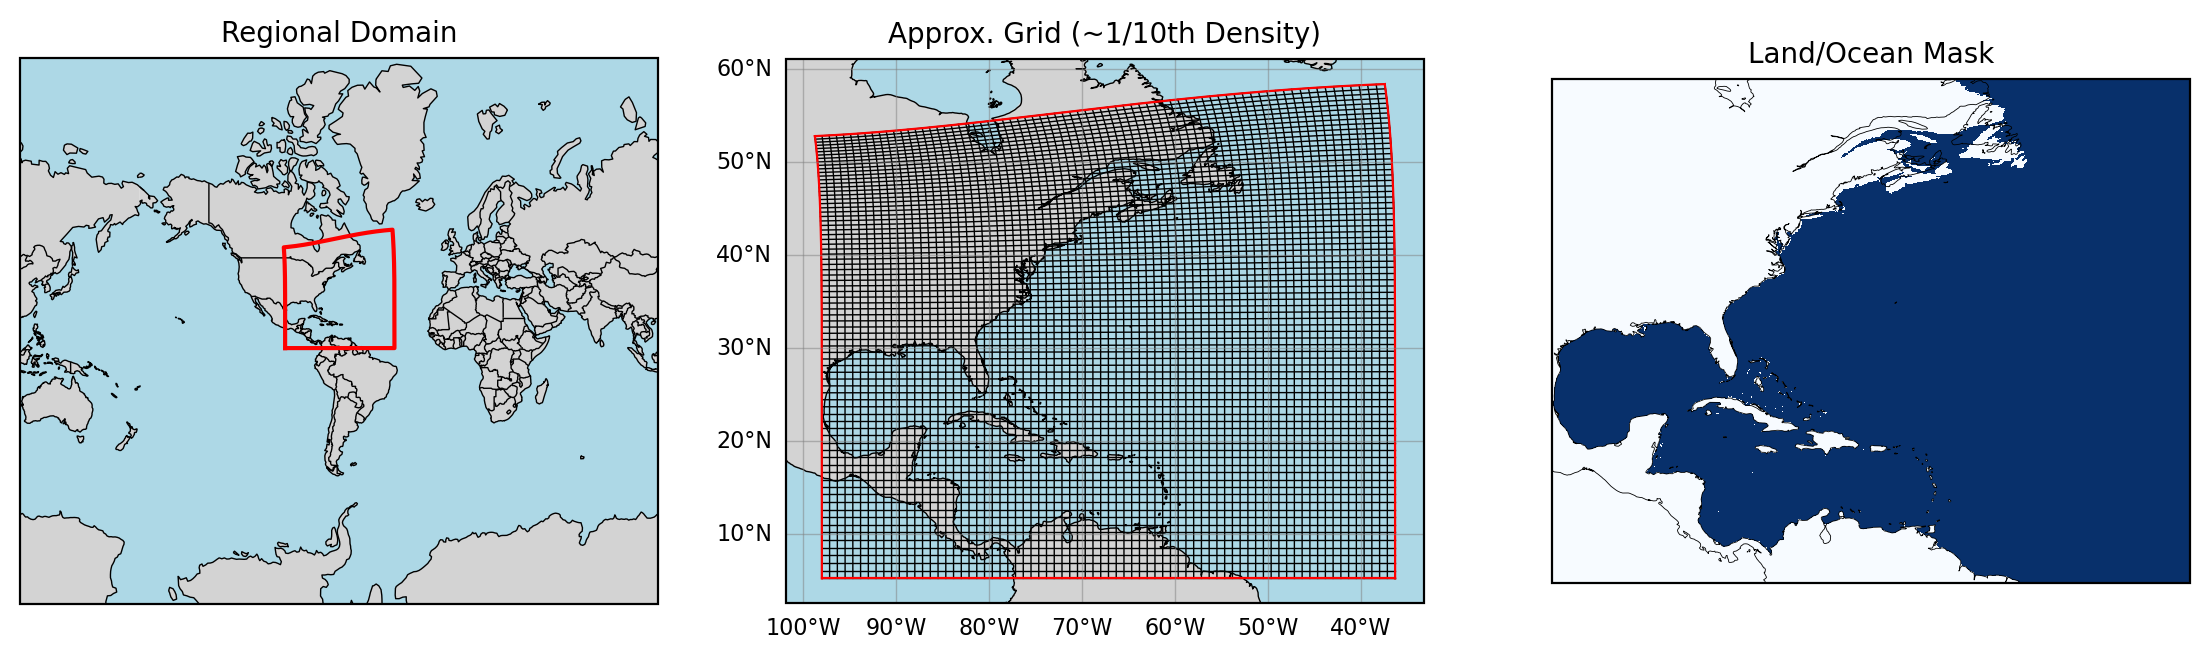

In [12]:
utils.visualizeRegionalDomain(static_data)

Taking mean and std dev from 2000-01-01 12:00:00 to 2000-10-31 12:00:00


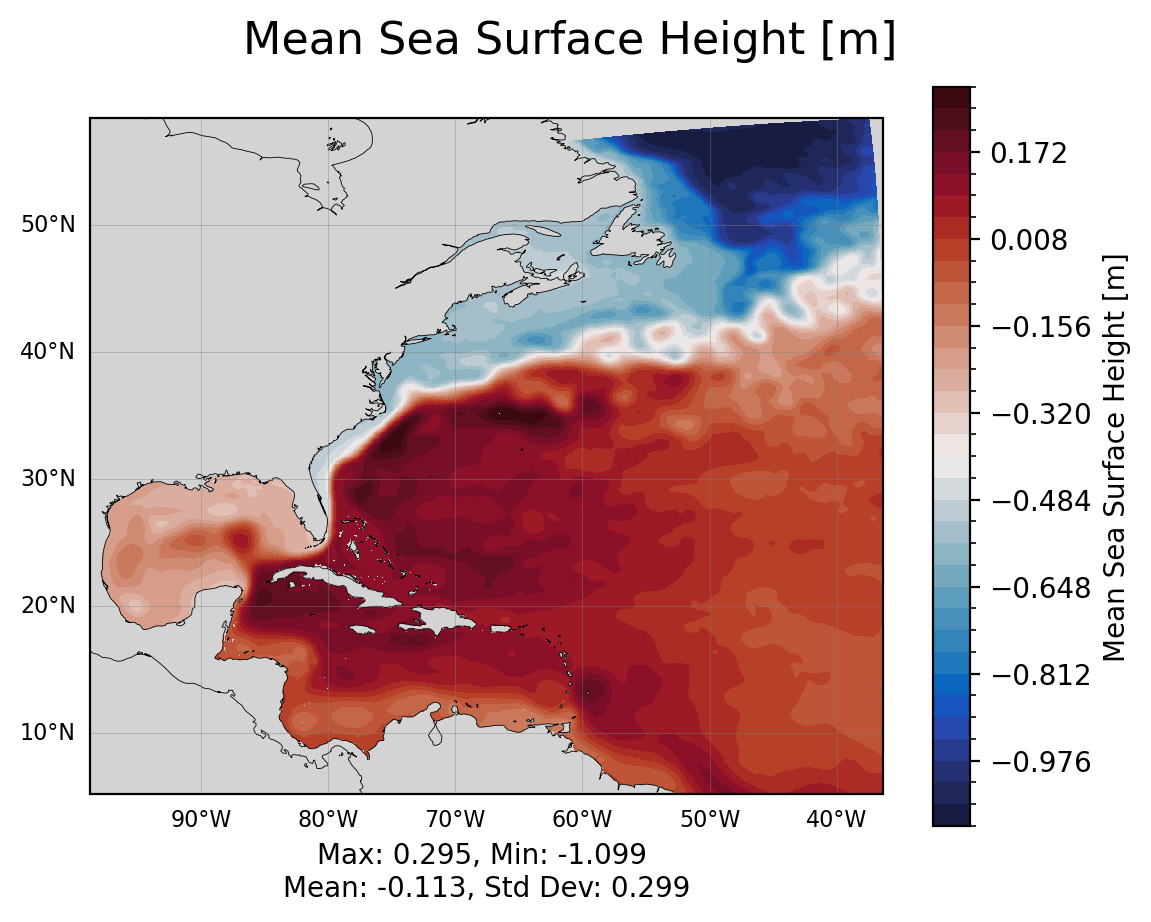

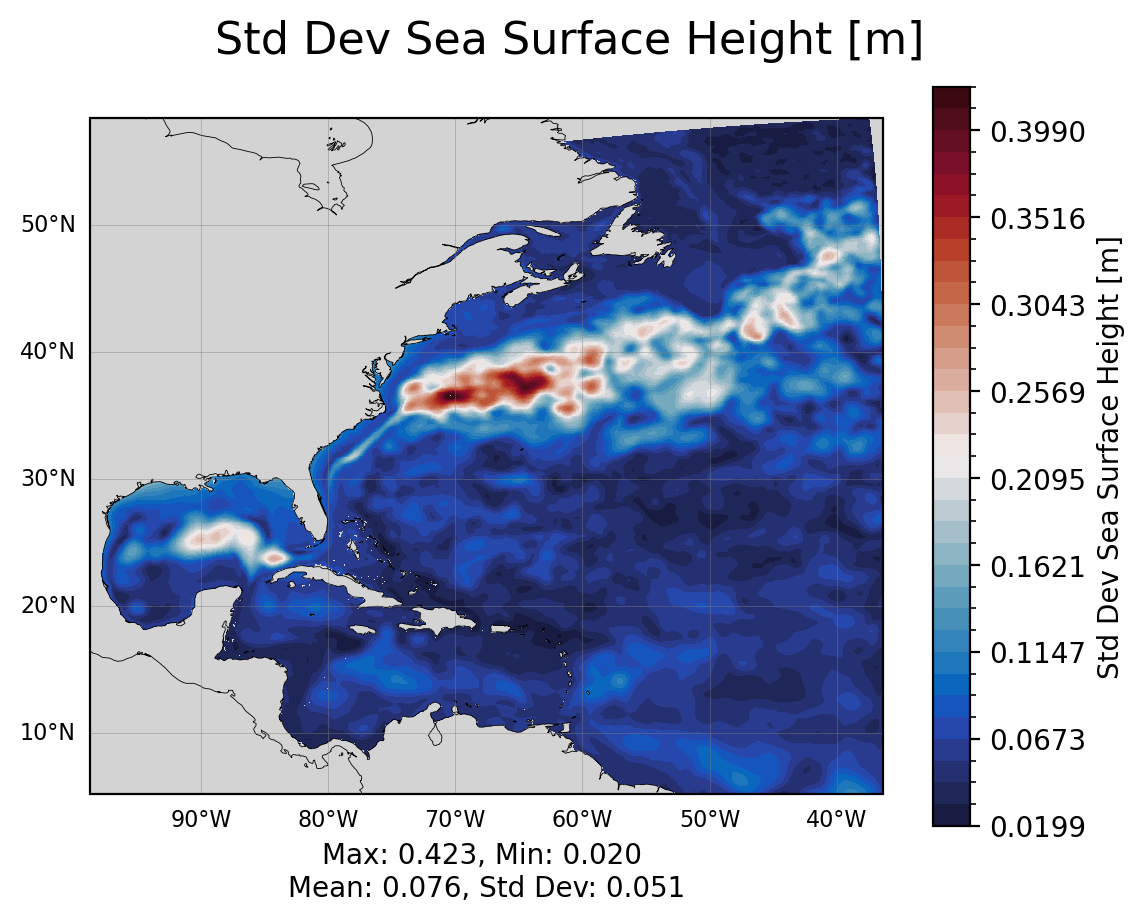

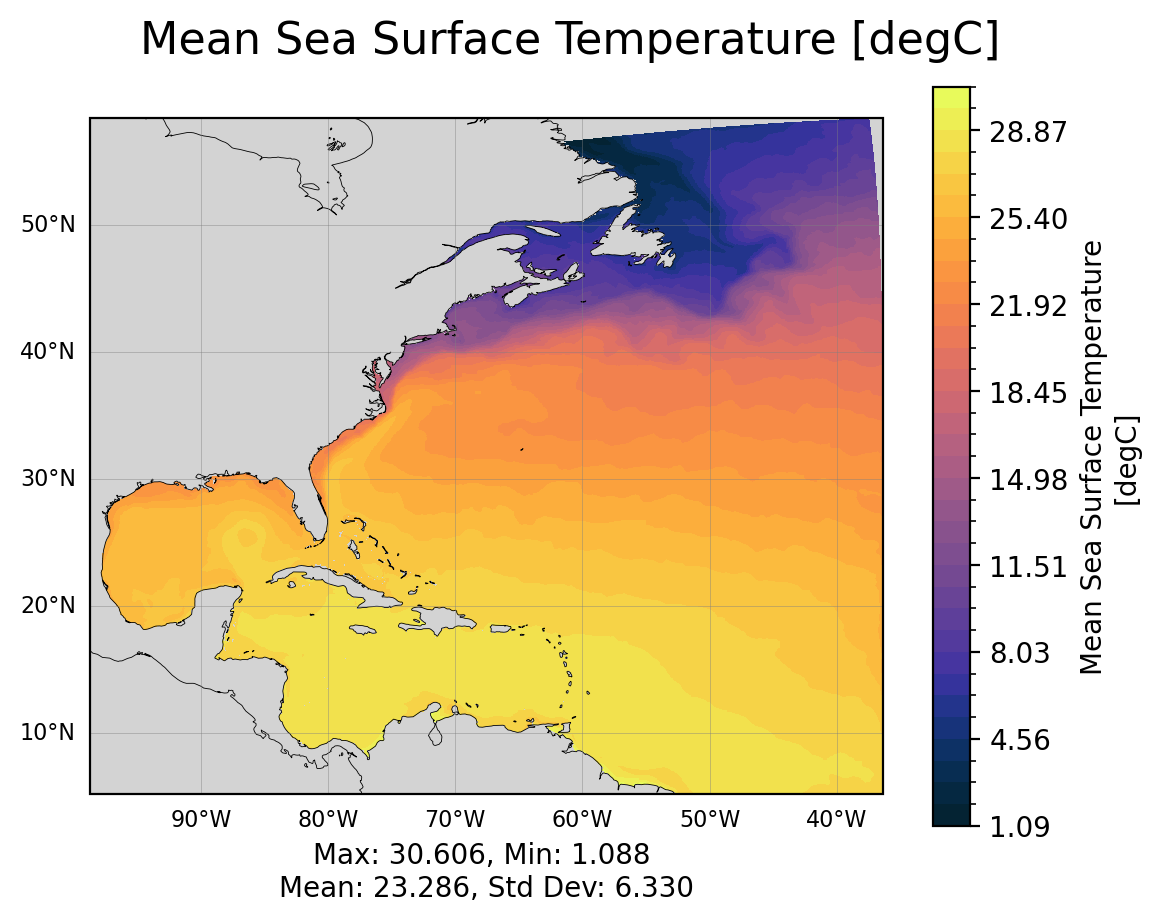

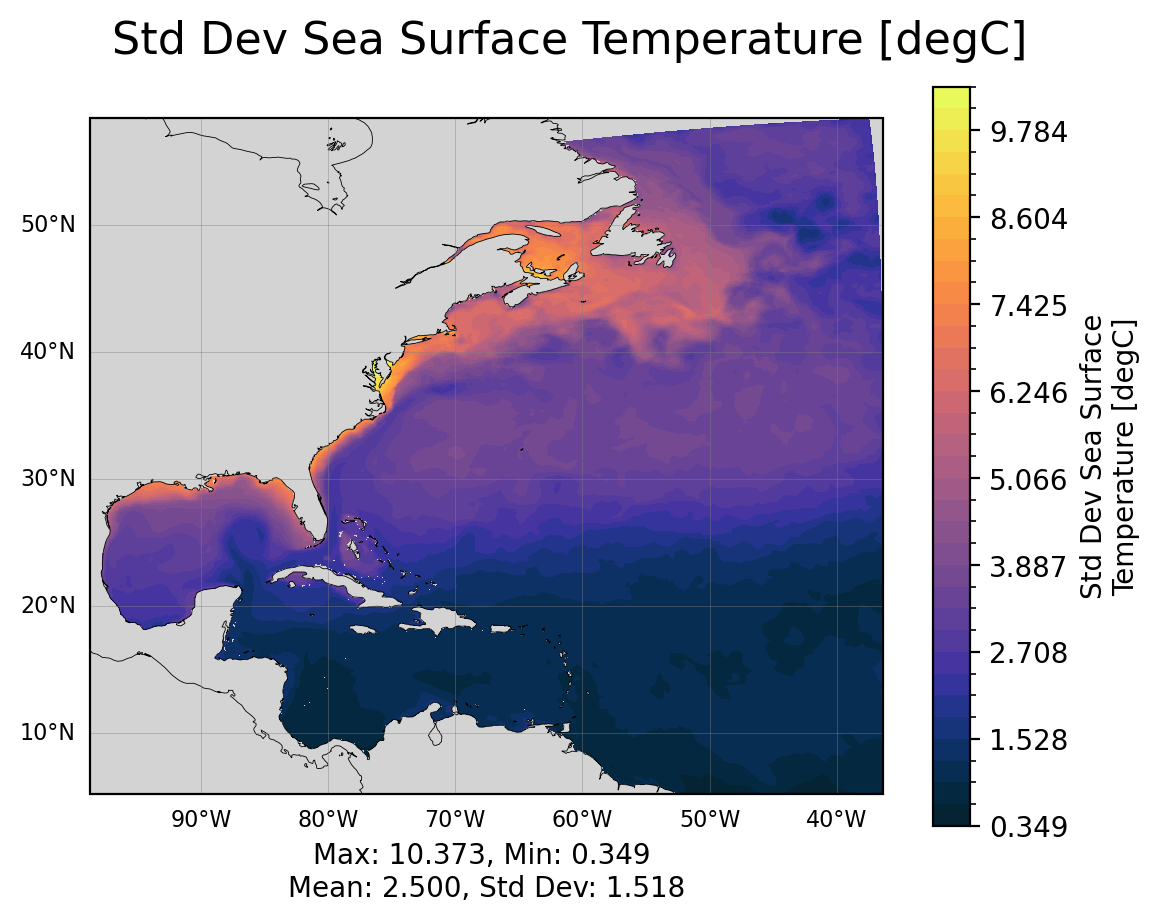

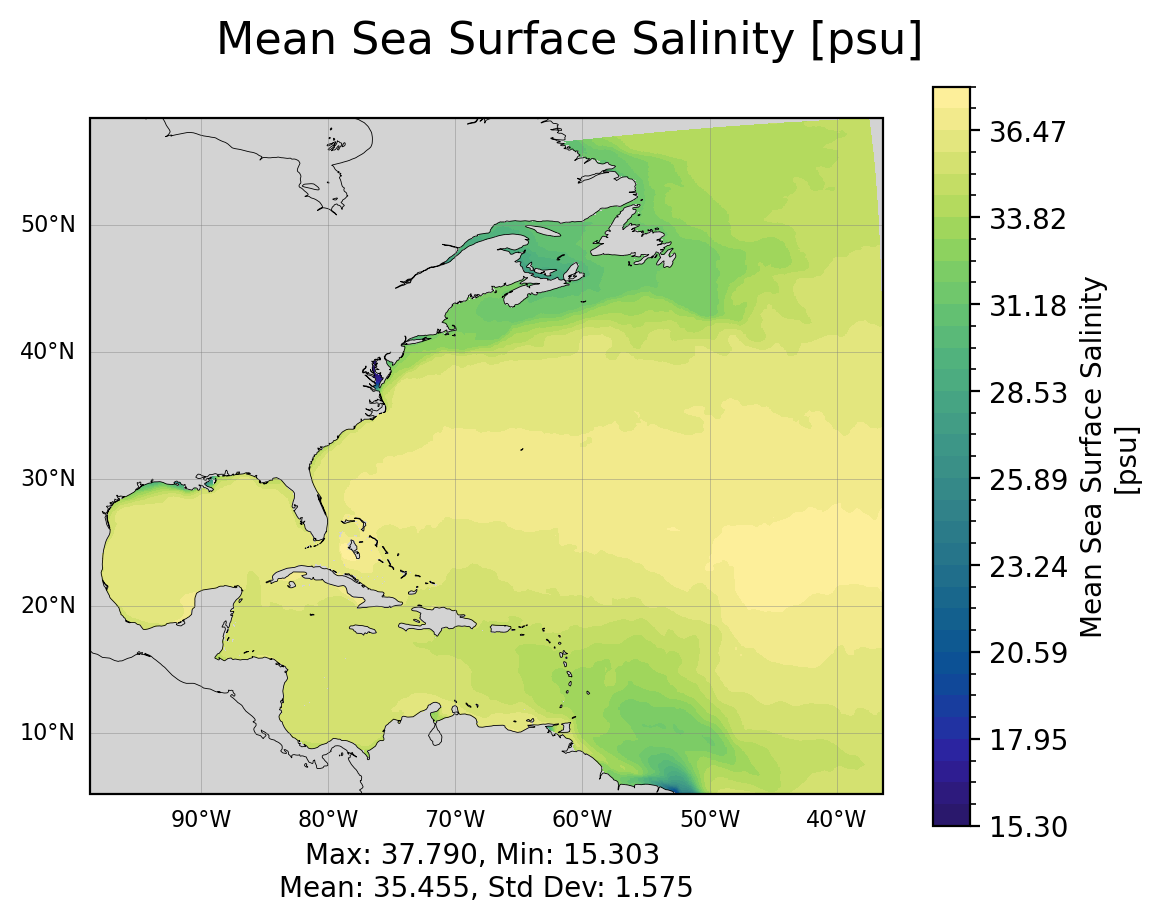

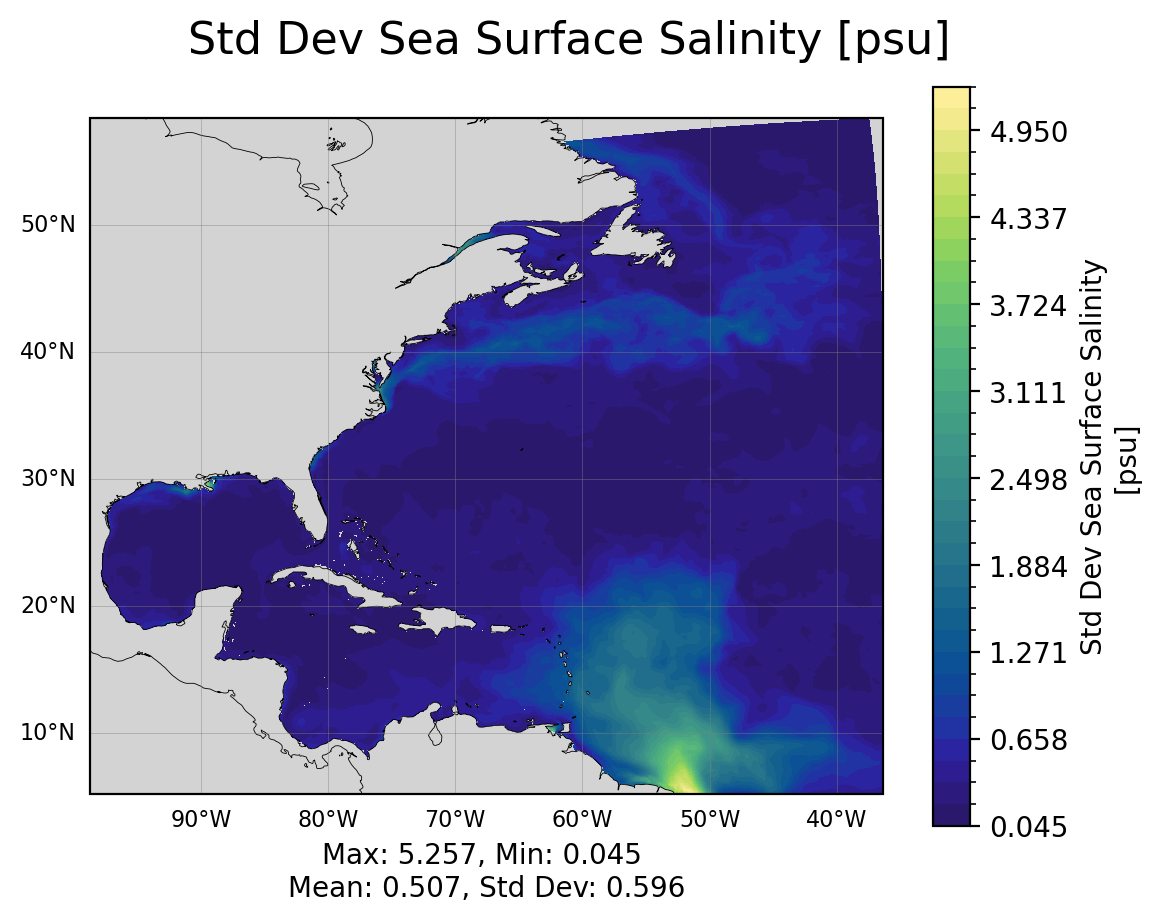

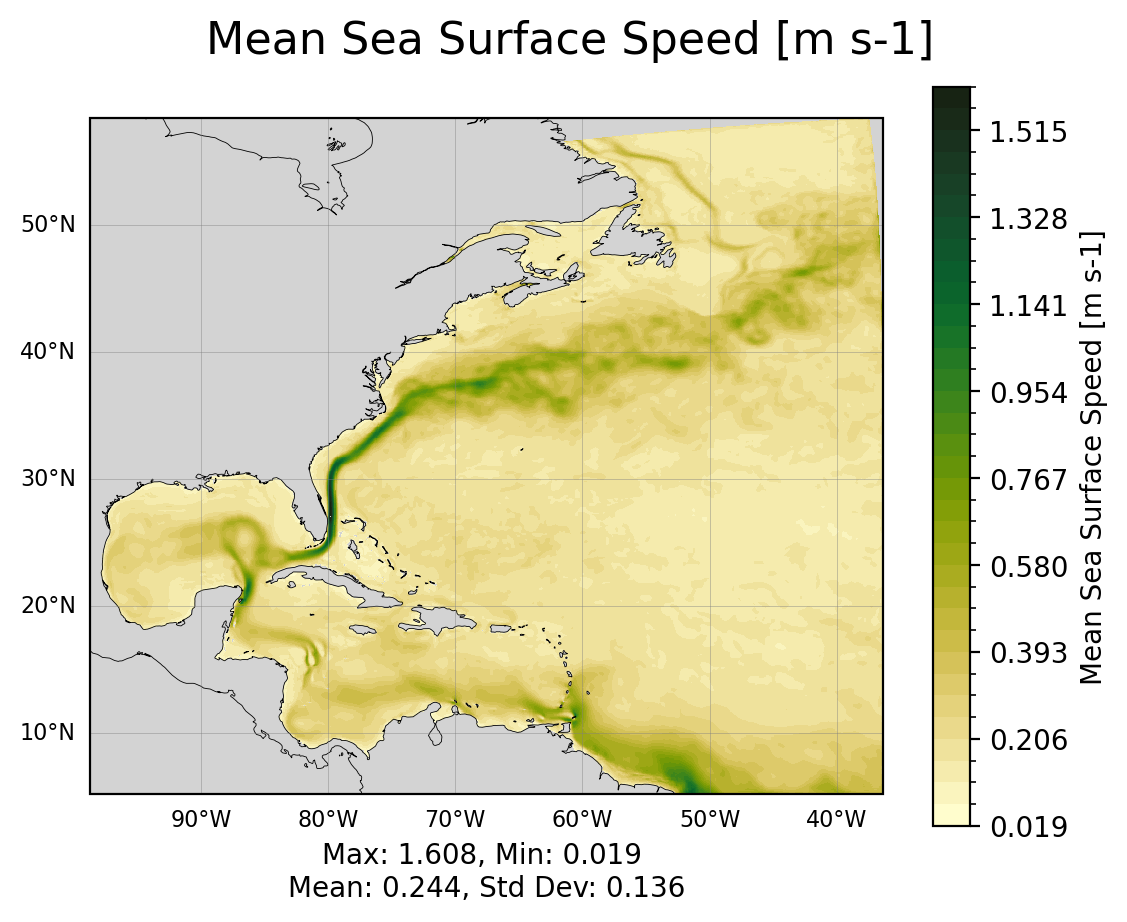

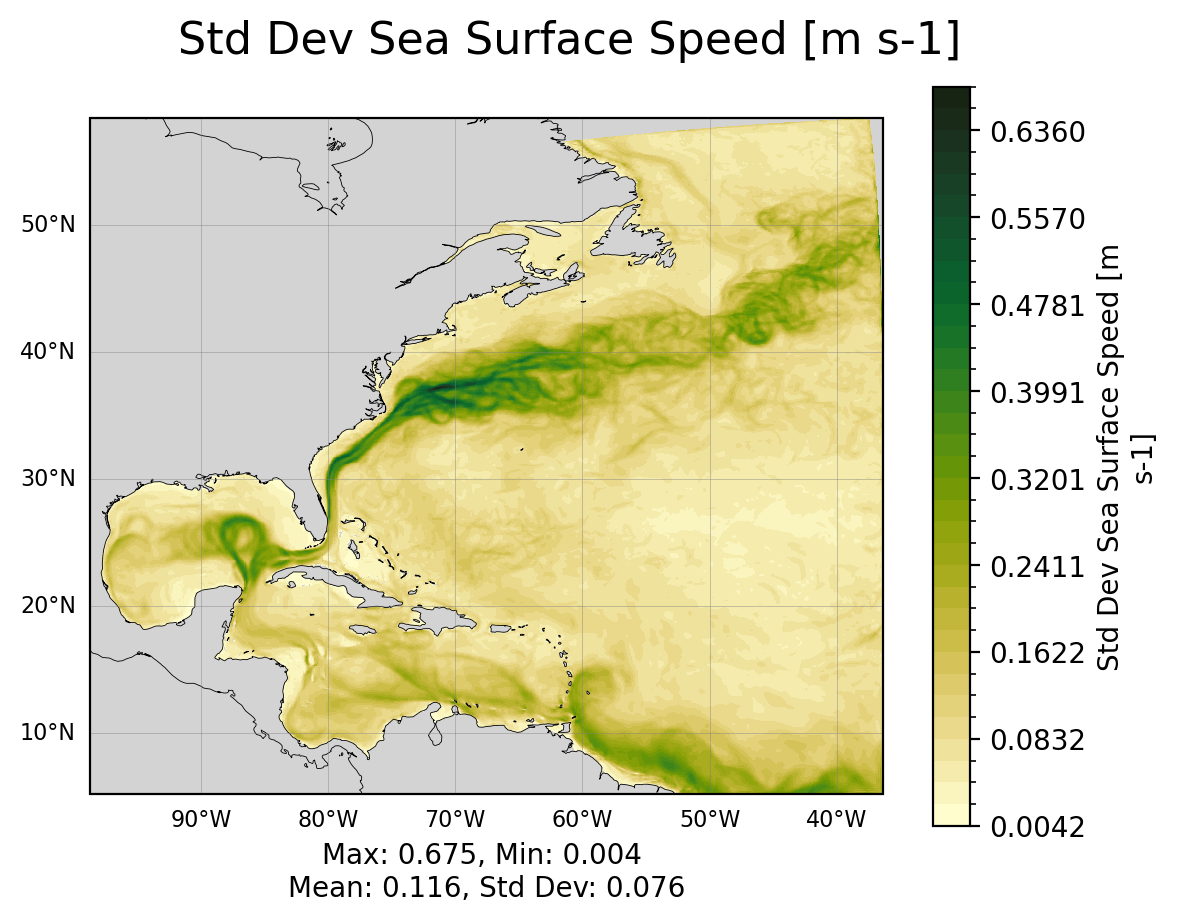

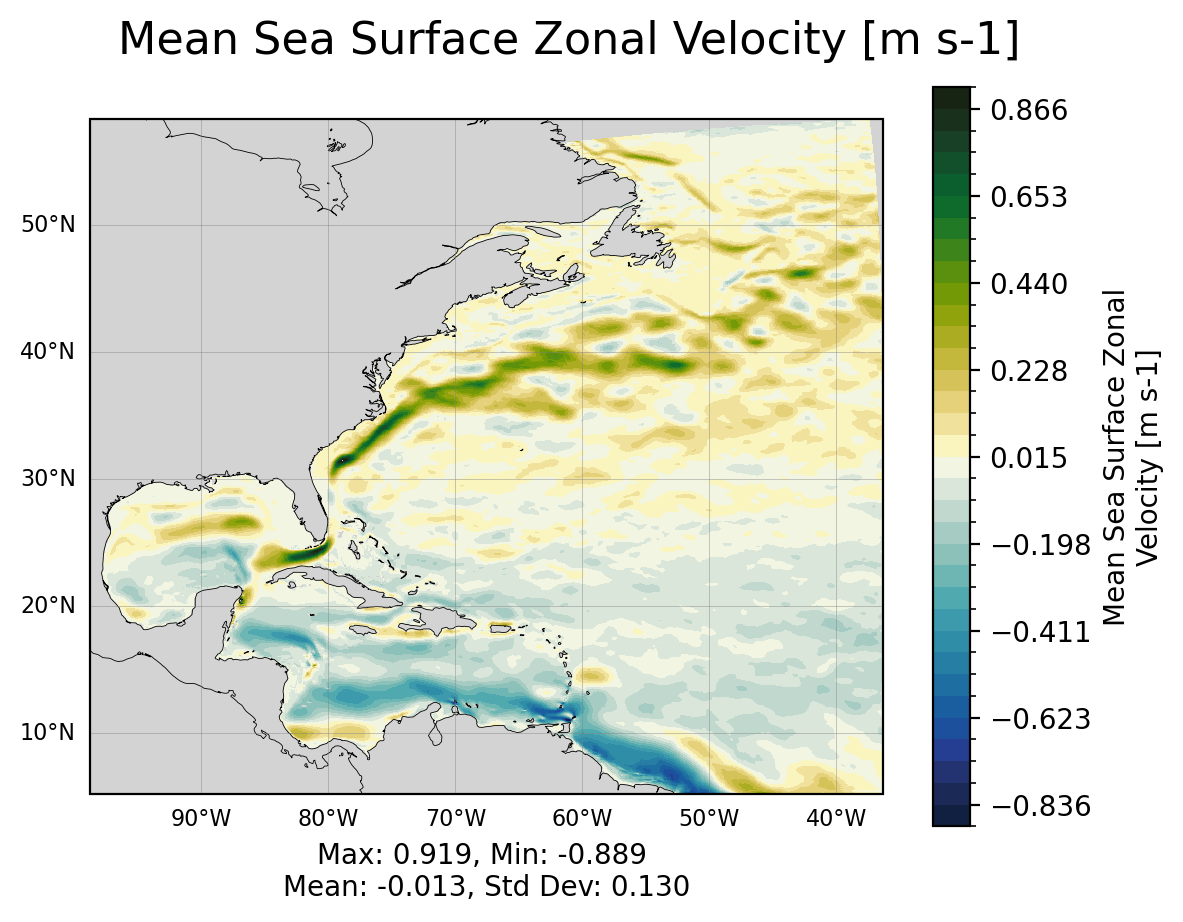

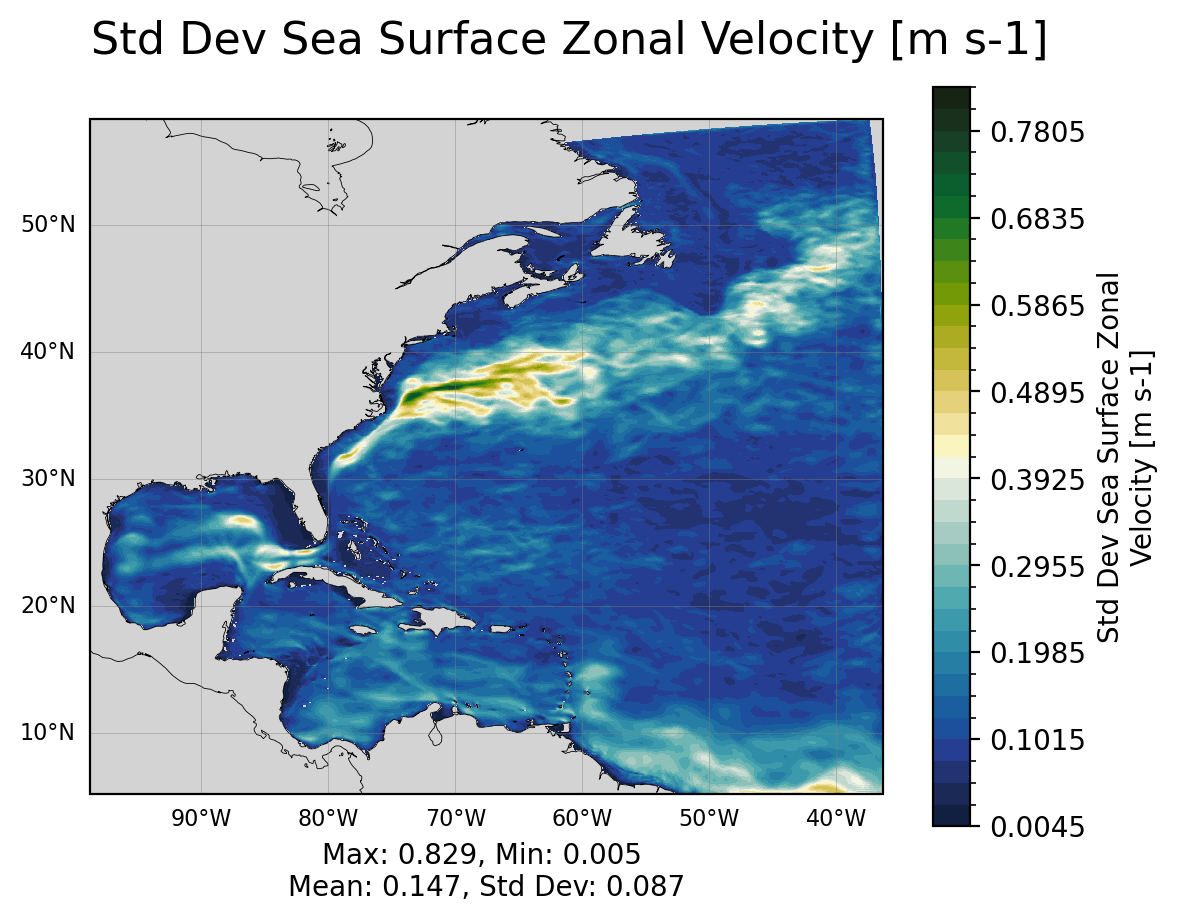

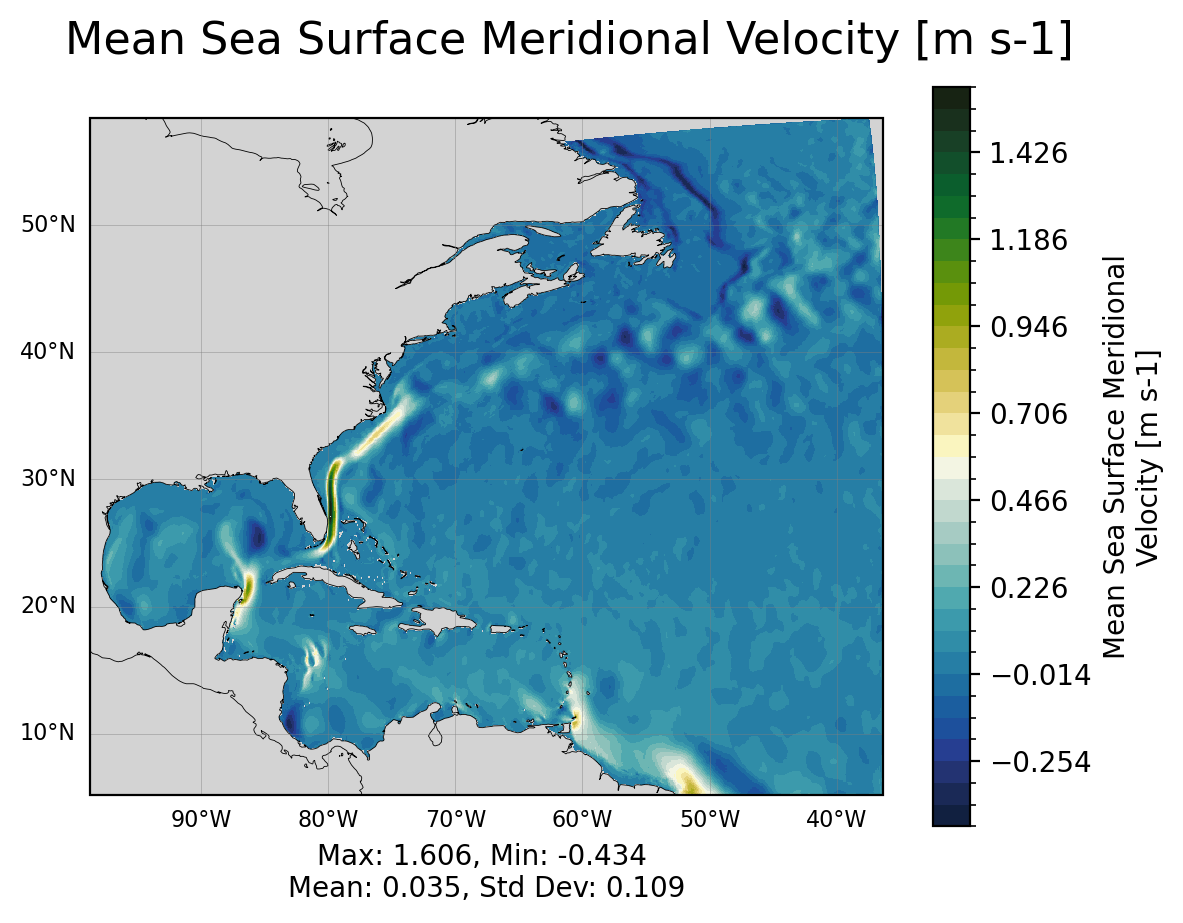

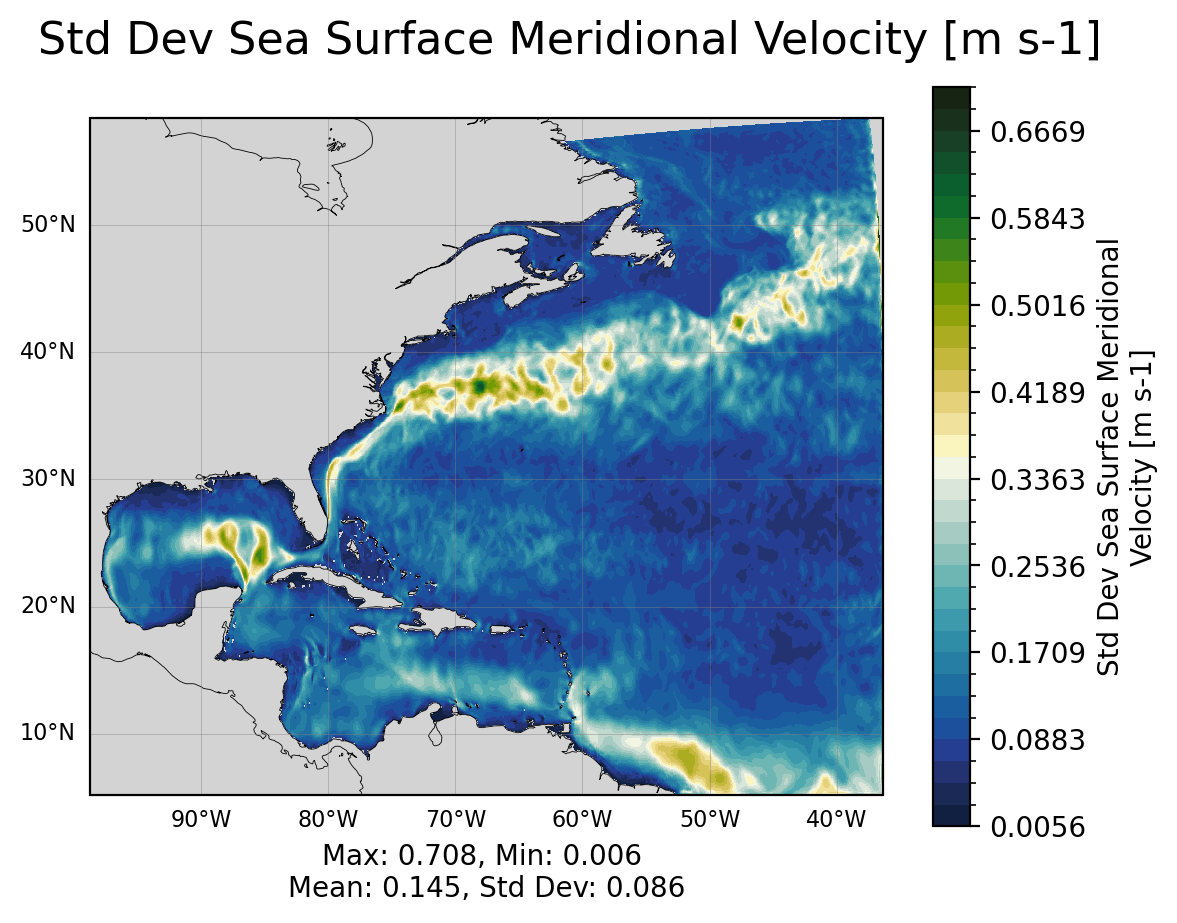

In [13]:
## Ploting basic state variables
variables = ["SSH", "tos", "sos", "speed", "SSU", "SSV"]
dataset = sfc_data
stats = True
time_bounds = (
    dataset["time"][0].compute().item(),
    dataset["time"][-1].compute().item(),
)


for var in variables:
    if var not in list(dataset.variables):
        print(f"Variable '{var}' not in given dataset. It will not be plotted.")
        variables.remove(var)


print(f"Taking mean and std dev from {time_bounds[0]} to {time_bounds[-1]}")
for var in variables:
    field = dataset[var]

    coords = utils.chooseGeoCoords(field.dims)
    areacello = utils.chooseAreacello(field.dims)

    mean = field.mean(dim="time", skipna=True).compute()
    std = field.std(dim="time", skipna=True).compute()
    mean.attrs = field.attrs
    std.attrs = field.attrs
    mean.attrs["long_name"] = f"Mean {field.long_name}"
    std.attrs["long_name"] = f"Std Dev {field.long_name}"

    utils.plotLatLonField(
        mean,
        latitude=static_data[coords["latitude"]],
        longitude=static_data[coords["longitude"]],
        stats=stats,
        area_weights=static_data[areacello],
        save=savefigs,
        save_path=image_output_dir,
    )
    plt.show()

    utils.plotLatLonField(
        std,
        latitude=static_data[coords["latitude"]],
        longitude=static_data[coords["longitude"]],
        stats=stats,
        area_weights=static_data[areacello],
        save=savefigs,
        save_path=image_output_dir,
    )
    plt.show()

## Area Weighted Averages and Timeseries

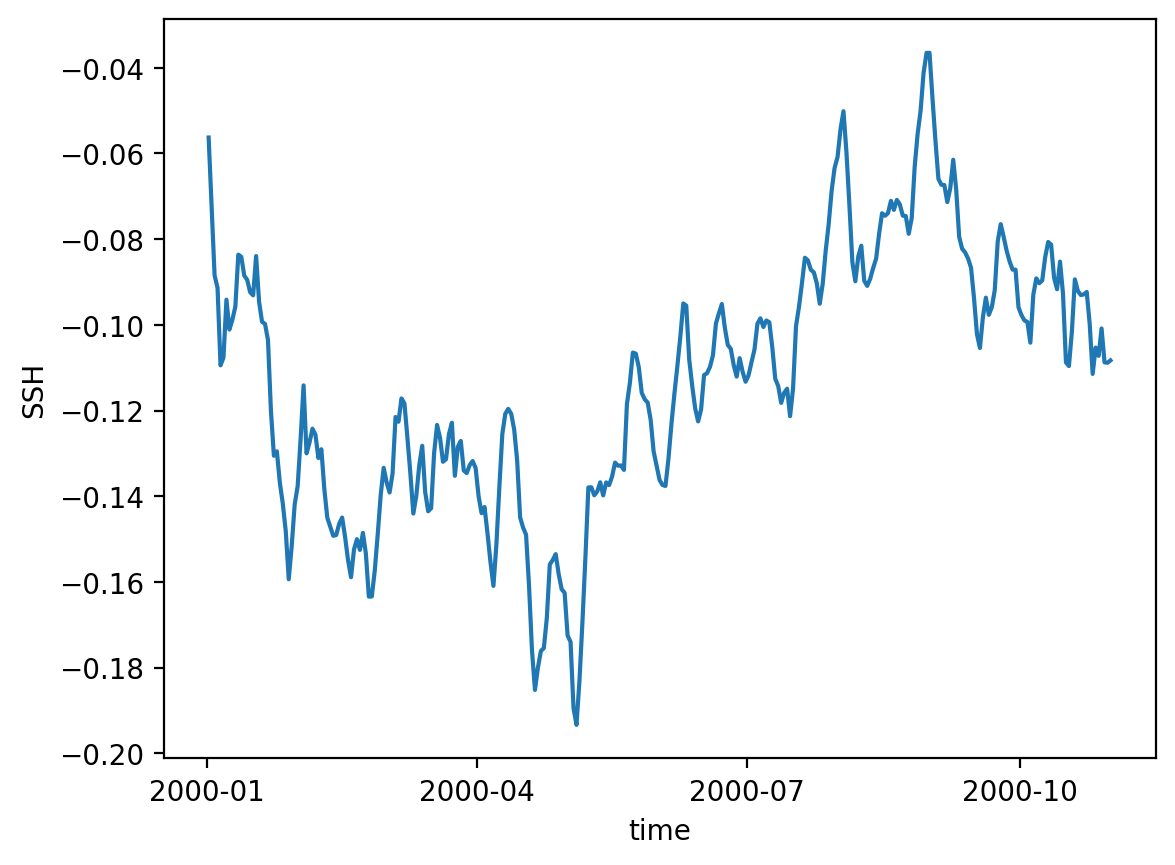

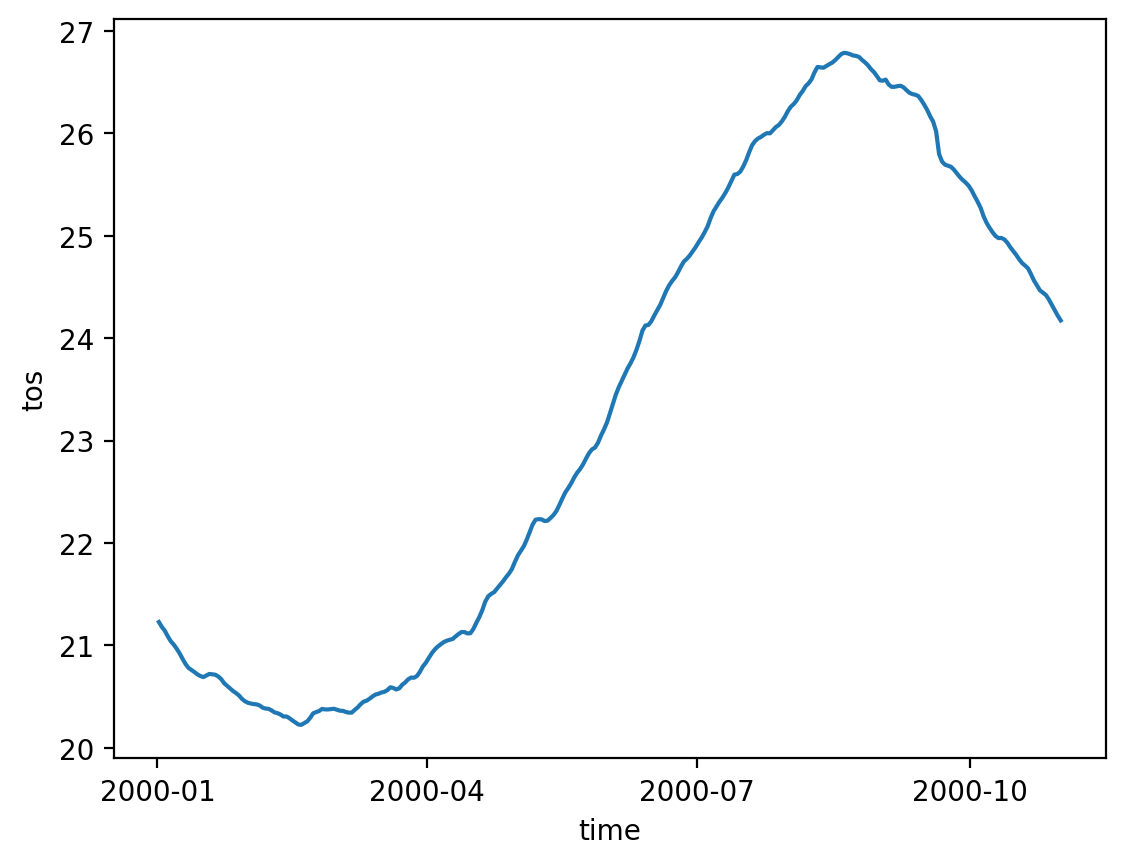

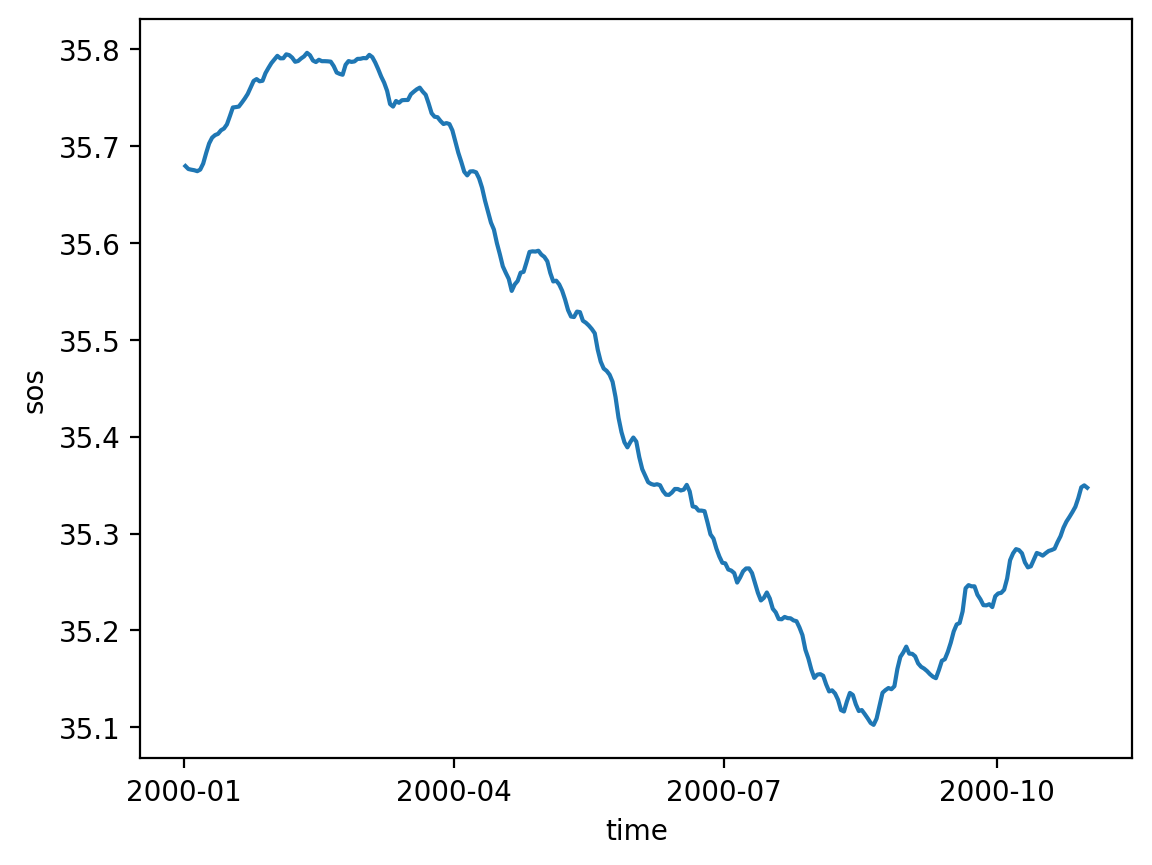

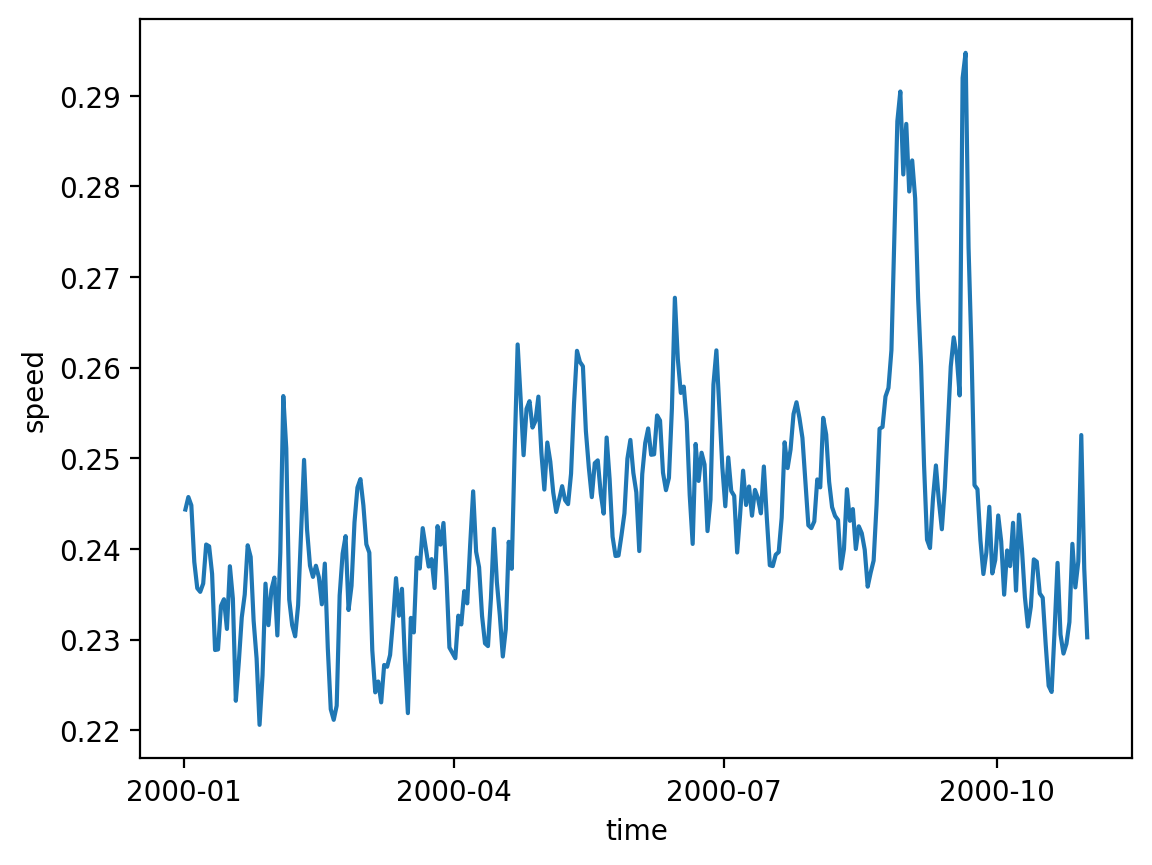

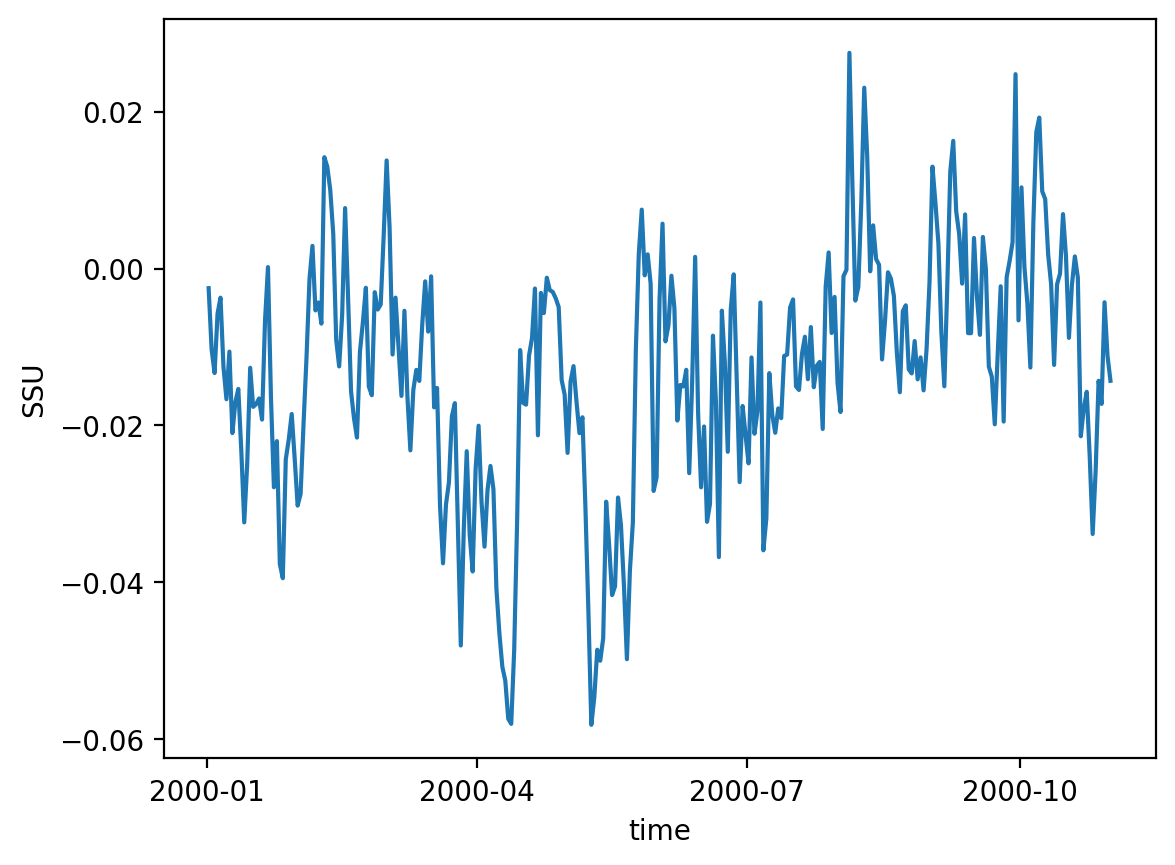

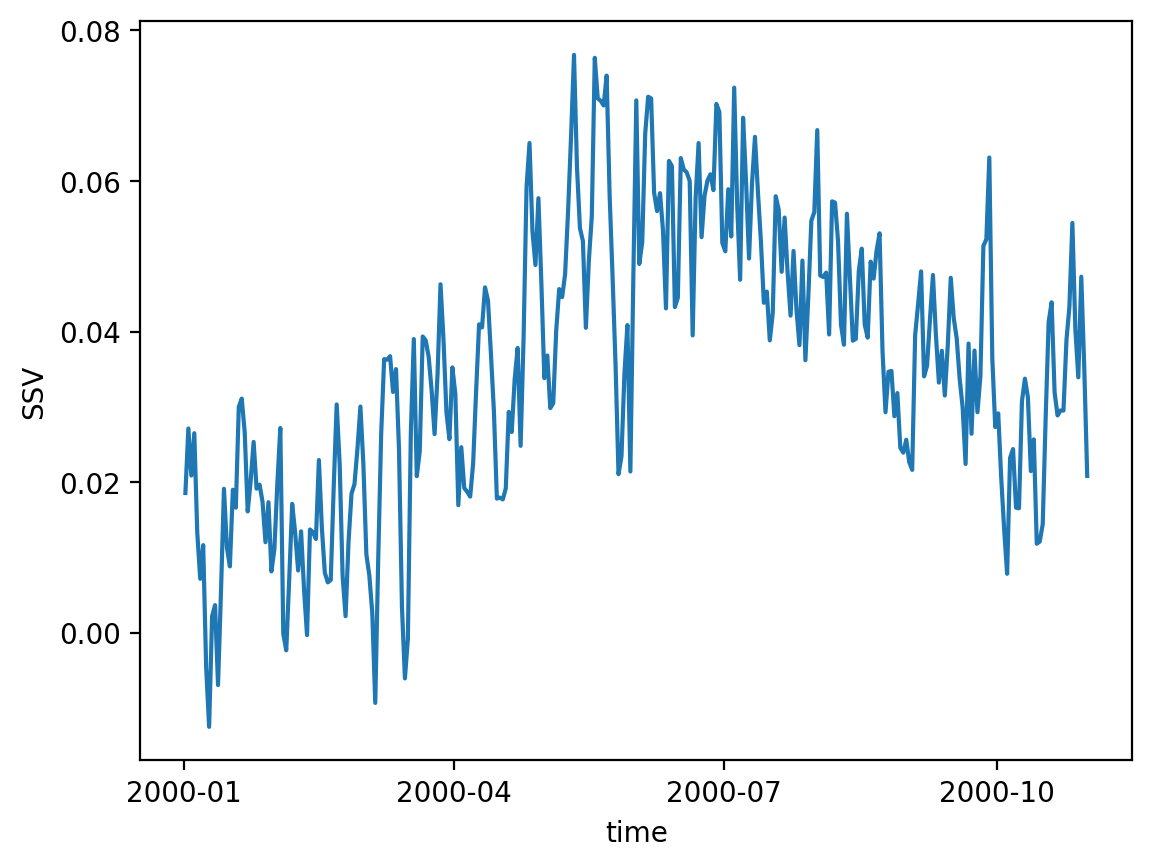

In [14]:
variables = ["SSH", "tos", "sos", "speed", "SSU", "SSV"]
dataset = sfc_data
for var in variables:
    field = dataset[var]
    areacello_var = utils.chooseAreacello(field.dims)

    utils.plotAvgTimseries(
        dataset[var],
        static_data[areacello_var],
        save=savefigs,
        save_path=image_output_dir,
    )